In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import dataframe_image as dfi

# Loading Files

In [2]:
my_path = '/Users/deagogishvili/Documents/GitHub/hydrophobic_patches/part3/MATERIALS'
file_path = '/Users/deagogishvili/Documents/GitHub/hydrophobic_patches/part3/FIGURES'

nsp_uniprot = my_path + '/NSP2.tab'
all_uniprot = my_path + '/UNIPROT.tab'
lhpsa = my_path + '/LHP_PREDICTIONS.tsv'
TM_uniprot = my_path + '/TM_ANNOTATIONS.tab'
COMPLEX_uniprot = my_path + '/COMPLEX_ANNOTATIONS.tab'
consensus = my_path + '/HPA_RNA_CONSENSUS.tsv'
lp_all = my_path + '/MOLPATCH.csv'
TMHMM = my_path + '/TMHMM.csv'

nsp_uniprot = pd.read_csv(nsp_uniprot, sep='\t', engine='python') #NSP2 predictions for Uniprot
lhpsa = pd.read_csv(lhpsa, sep='\t', engine='python') # LHP predictions
all_uniprot = pd.read_csv(all_uniprot, sep='\t', engine='python') #all information from Uniprot only
TM_uniprot = pd.read_csv(TM_uniprot, sep='\t', engine='python') #annotated transmembrane proteins
COMPLEX_uniprot = pd.read_csv(COMPLEX_uniprot, sep='\t', engine='python') #annotated proteins involved in complexes
consensus = pd.read_csv(consensus, sep='\t', engine='python') #mRNA expression consensus data from HPA
lp_all = pd.read_csv(lp_all, sep=',', engine='python') #Structure-based definitions from Molpatch
TMHMM = pd.read_csv(TMHMM, sep=',', engine='python') # TMHMM Predictions

In [3]:
# lhpsa = lhpsa.sort_values('prediction')
# lhpsa.head(50)

# Data Curation

In [4]:
print('all', len(nsp_uniprot.iloc[:,0]))

# Remove disordered proteins
nsp_uniprot = nsp_uniprot[nsp_uniprot['disorder'] < 0.5]
print('< 0.5 Disorder', len(nsp_uniprot.iloc[:,0]))

# Remove Large proteins
#nsp_uniprot['length'] = nsp_uniprot['length'].astype(float)
nsp_uniprot = nsp_uniprot[nsp_uniprot['length'] <= 800]
print('Short Proteins', len(nsp_uniprot.iloc[:,0]))

all 20384
< 0.5 Disorder 17771
Short Proteins 14706


In [5]:
all_uniprot.columns = ['id', 'x1', 'x2', 'x3', 'Gene_ID', 'x4', 'x5', 'x6', 'length']
all_uniprot = all_uniprot[['id', 'Gene_ID','length']]
all_uniprot = all_uniprot.dropna(subset = ['Gene_ID'])

hg = nsp_uniprot[['id', 'thsa_netsurfp2', 'rhsa_netsurfp2']] # hg = human genome
hg = pd.merge(hg, all_uniprot, on='id')
hg = pd.merge(hg, lhpsa, on='id')
hg = hg.rename(columns = {'id': 'Uniprot_ID', 'thsa_netsurfp2': 'THSA', 'rhsa_netsurfp2':'RHSA', 'prediction':'LHPSA'}, inplace = False)
hg = hg[['Uniprot_ID', 'Gene_ID', 'THSA', 'RHSA', 'LHPSA', 'length']]
print(len(hg.iloc[:,0]))

# discart multiple Gene_IDs, keep only the first one
hg['Gene_ID'] = hg['Gene_ID'].astype(str)
hg['Gene_ID'] = [x.split(';')[0] for x in hg['Gene_ID']]

# Discard duplicate Gene_ID, keep the one with the highest THSA
hg = hg.sort_values('THSA').drop_duplicates(subset=['Gene_ID'], keep='last') 
print(len(hg.iloc[:,0]))

# Remove NaNs from Gene names
hg = hg.dropna(subset = ['Gene_ID'])
print(len(hg.iloc[:,0]))

14580
14533
14533


# Transmembrane proteins in it

In [6]:
TM_uniprot = list(TM_uniprot['Entry'])
#hg_without_tm = hg[~hg['Uniprot_ID'].isin(TM_uniprot)]
#print(len(hg_without_tm.iloc[:,0]))

In [7]:
TM = hg[hg['Uniprot_ID'].isin(TM_uniprot)]
print(len(TM.iloc[:,0]))

4913


# proteins involved in complexes

In [8]:
COMPLEX_uniprot = list(COMPLEX_uniprot['Entry'])
#hg_without_comp = hg[~hg['Uniprot_ID'].isin(COMPLEX_uniprot)]
#print(len(hg_without_comp.iloc[:,0]))

In [9]:
COMP = hg[hg['Uniprot_ID'].isin(COMPLEX_uniprot)]
print(len(COMP.iloc[:,0]))

6825


# rnk files for GSEA without scaling

In [8]:
# save files without normalizing including transmembrane proteins

THSA_GSEA = hg[['Gene_ID', 'THSA']]
THSA_GSEA = THSA_GSEA.sort_values(by=['THSA'], ascending=False)

RHSA_GSEA = hg[['Gene_ID', 'RHSA']]
RHSA_GSEA = RHSA_GSEA.sort_values(by=['RHSA'], ascending=False)

LHPSA_GSEA = hg[['Gene_ID', 'LHPSA']]
LHPSA_GSEA = LHPSA_GSEA.sort_values(by=['LHPSA'], ascending=False)

# THSA_GSEA.to_csv(my_path + '/GSEA/THSA_GSEA.rnk', sep= '\t', index = False, header=False)
# RHSA_GSEA.to_csv(my_path + '/GSEA/RHSA_GSEA.rnk', sep= '\t', index = False, header=False)
# LHPSA_GSEA.to_csv(my_path +'/GSEA/LHPSA_GSEA.rnk', sep= '\t', index = False, header=False)

# Scaling

In [10]:
import pandas as pd
import os
from sys import argv
import numpy as np

In [11]:
# Files with non-normalized scores
f_in1 = my_path + '/GSEA/THSA_GSEA.rnk'
f_in2 = my_path + '/GSEA/RHSA_GSEA.rnk'
f_in3 = my_path +'/GSEA/LHPSA_GSEA.rnk'

# Output files
f_out1 = my_path + '/GSEA/THSA_GSEA_cs.rnk'
f_out2 = my_path + '/GSEA/RHSA_GSEA_cs.rnk'
f_out3 = my_path +'/GSEA/LHPSA_GSEA_cs.rnk'

In [12]:
### Calculate normalized scores
# THSA
scores = []
with open(f_in1, 'r') as f:
    for line in f:
        scores.append(float(line.strip().split('\t')[1]))
median = np.median(scores)
sd = np.std(scores)
print('THSA', median, sd)

with open(f_in1, 'r') as infile:
    with open(f_out1, 'w') as outfile:
        for line in infile:
            splitline = line.strip().split('\t')
            name = splitline[0]
            score = float(splitline[1])
            newscore = (score - median - 1900) / sd
            
            outfile.write('%s\t%f\n' % (name, newscore))
            
# RHSA
scores = []
with open(f_in2, 'r') as f:
    for line in f:
        scores.append(float(line.strip().split('\t')[1]))
median = np.median(scores)
sd = np.std(scores)
print('RHSA', median, sd)

with open(f_in2, 'r') as infile:
    with open(f_out2, 'w') as outfile:
        for line in infile:
            splitline = line.strip().split('\t')
            name = splitline[0]
            score = float(splitline[1])
            newscore = (score - median - 0.08) / sd

            outfile.write('%s\t%f\n' % (name, newscore))
            
# Largest patch
scores = []
with open(f_in3, 'r') as f:
    for line in f:
        scores.append(float(line.strip().split('\t')[1]))
median = np.median(scores)
sd = np.std(scores)
print('LHPSA', median, sd)

with open(f_in3, 'r') as infile:
    with open(f_out3, 'w') as outfile:
        for line in infile:
            splitline = line.strip().split('\t')
            name = splitline[0]
            score = float(splitline[1])
            newscore = (score - median - 200) / sd

            outfile.write('%s\t%f\n' % (name, newscore))

THSA 6212.794929581879 3127.7070176959423
RHSA 0.2745877587641072 0.0953251856624628
LHPSA 1457.4130348785516 1790.388084545147


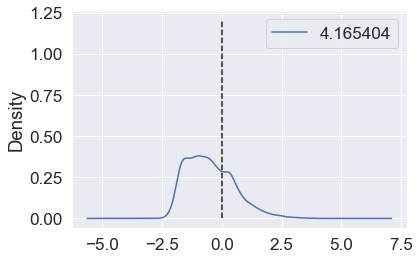

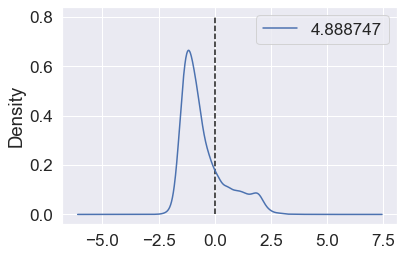

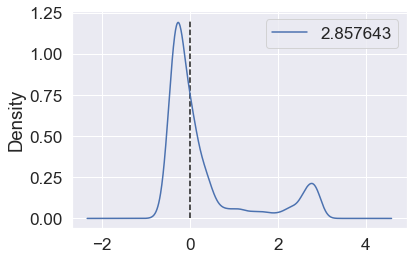

In [66]:
# Input files
f_in1 = my_path + '/GSEA/THSA_GSEA_cs.rnk'
f_in2 = my_path + '/GSEA/RHSA_GSEA_cs.rnk'
f_in3 = my_path +'/GSEA/LHPSA_GSEA_cs.rnk'

# Output files
f_out1 = my_path + '/GSEA/THSA_GSEA_cs.png'
f_out2 = my_path + '/GSEA/RHSA_GSEA_cs.png'
f_out3 = my_path +'/GSEA/LHPSA_GSEA_cs.png'

### Create plots
plt.rc('font', size=18)

# THSA
df = pd.read_csv(f_in1, sep='\t')
ax = df.plot.density().get_figure()
plt.vlines(0, 0, 1.2, linestyles='dashed')
ax.savefig(f_out1)

# RHSA
df = pd.read_csv(f_in2, sep='\t')
ax = df.plot.density().get_figure()
plt.vlines(0, 0, 0.8, linestyles='dashed')
ax.savefig(f_out2)

# LHPSA
df = pd.read_csv(f_in3, sep='\t')
ax = df.plot.density().get_figure()
plt.vlines(0, 0, 1.2, linestyles='dashed')
ax.savefig(f_out3)

# Without Transmembrane Proteins 

# Plotting Distribution Figures

In [11]:
print('------------Structure-based Data---------------------------')

print('MEDIAN THSA', lp_all['thsa'].median())
print('MEDIAN RHSA', lp_all['rhsa'].median())
print('MEDIAN LHP', lp_all['size'].median())
print('MEDIAN length', lp_all['length'].median())


print('------------HUMAN PROTEOME---------------------------')

print('MEDIAN THSA', hg['THSA'].median())
print('MEDIAN RHSA', hg['RHSA'].median())
print('MEDIAN LHP', hg['LHPSA'].median())
print('MEDIAN length', hg['length'].median())

print('------------MULTIMERI PROTEINS-----------------------')

print('MEDIAN THSA', COMP['THSA'].median())
print('MEDIAN RHSA', COMP['RHSA'].median())
print('MEDIAN LHP', COMP['LHPSA'].median())
print('MEDIAN length', COMP['length'].median())

print('------------TRANSMEMBRANE PROTEINS-------------------')

print('MEDIAN THSA', TM['THSA'].median())
print('MEDIAN RHSA', TM['RHSA'].median())
print('MEDIAN LHP', TM['LHPSA'].median())
print('MEDIAN length', TM['length'].median())

------------Structure-based Data---------------------------
MEDIAN THSA 2720.0
MEDIAN RHSA 0.2363425590494131
MEDIAN LHP 877.0
MEDIAN length 228.0
------------HUMAN PROTEOME---------------------------
MEDIAN THSA 6212.794929581879
MEDIAN RHSA 0.2745877587641072
MEDIAN LHP 1457.4130348785516
MEDIAN length 352.0
------------MULTIMERI PROTEINS-----------------------
MEDIAN THSA 5880.526148334146
MEDIAN RHSA 0.265402598832009
MEDIAN LHP 1247.199980222698
MEDIAN length 365.0
------------TRANSMEMBRANE PROTEINS-------------------
MEDIAN THSA 8210.603422847387
MEDIAN RHSA 0.3797987521688591
MEDIAN LHP 3236.0372601462896
MEDIAN length 342.0


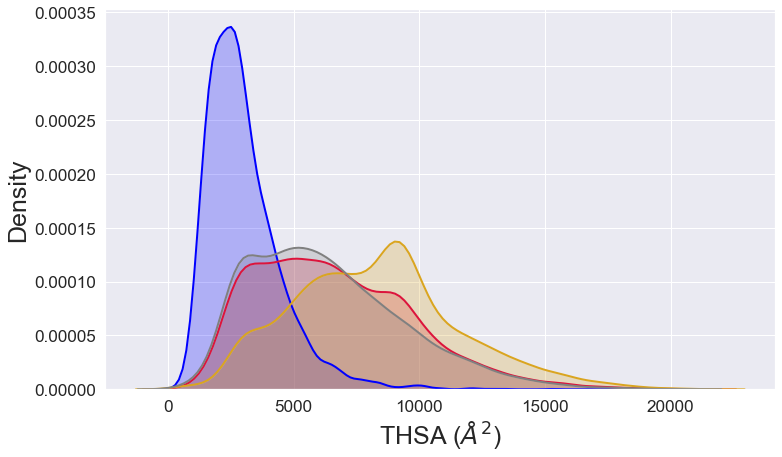

In [12]:
sns.set_style('ticks')
sns.set(font_scale = 1.55)
fig, ax = plt.subplots(0,0)
fig.set_size_inches(12, 7)

sns.distplot(lp_all['thsa'], hist=False, kde=True, color='Blue', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(hg['THSA'], hist=False, kde=True, color='crimson', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(TM['THSA'], hist=False, kde=True, color='goldenrod', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(COMP['THSA'], hist=False, kde=True, color='grey', kde_kws={'shade': True, 'linewidth': 2})
# legend = ['Structure-based set (2720 $Å^2$)','Human proteome (7889 $Å^2$)', 'Transmembrane (8211 $Å^2$)', 'Multimeric (5880 $Å^2$)']
# plt.legend(legend, prop={'size': 20}) #, title = 'Data Set')
plt.title('',  size=30)
plt.xlabel('THSA ($Å^2$)',  size=25)
plt.ylabel('Density',  size=25)
fig.savefig(file_path + '/THSA.png', dpi = 150)

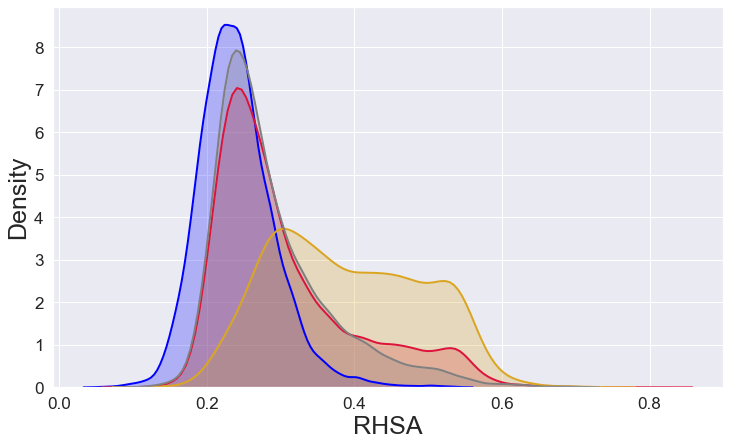

In [13]:
fig, ax = plt.subplots(0,0)
fig.set_size_inches(12, 7)

sns.distplot(lp_all['rhsa'], hist=False, kde=True, color='Blue', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(hg['RHSA'], hist=False, kde=True, color='crimson', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(TM['RHSA'], hist=False, kde=True, color='goldenrod', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(COMP['RHSA'], hist=False, kde=True, color='grey', kde_kws={'shade': True, 'linewidth': 2})

# legend = ['Structure-based set (0.24)','Human proteome (0.29)', 'Transmembrane (0.38)', 'Multimeric (0.27)']
# plt.legend(legend, prop={'size': 20}) #, title = 'Data Set')

plt.xlabel('RHSA',  size=25)
plt.ylabel('Density',  size=25)
fig.savefig(file_path + '/RHSA.png', dpi = 150)

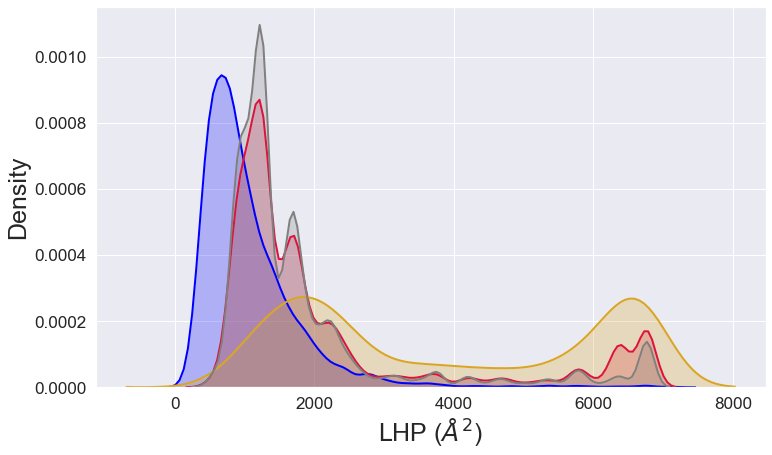

In [14]:
fig, ax = plt.subplots(0,0)
fig.set_size_inches(12, 7)

sns.distplot(lp_all['size'], hist=False, kde=True, color='Blue', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(hg['LHPSA'], hist=False, kde=True, color='crimson', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(TM['LHPSA'], hist=False, kde=True, color='goldenrod', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(COMP['LHPSA'], hist=False, kde=True, color='grey', kde_kws={'shade': True, 'linewidth': 2})

# legend = ['Structure-based set (877 $Å^2$)','Human proteome (1835 $Å^2$)', 'Transmembrane (3236 $Å^2$)', 'Multimeric (1247 $Å^2$)']
# plt.legend(legend, prop={'size': 20}) #, title = 'Data Set')

plt.xlabel('LHP ($Å^2$)',  size=25)
plt.ylabel('Density',  size=25)
fig.savefig(file_path + '/LHP.png', dpi = 150)

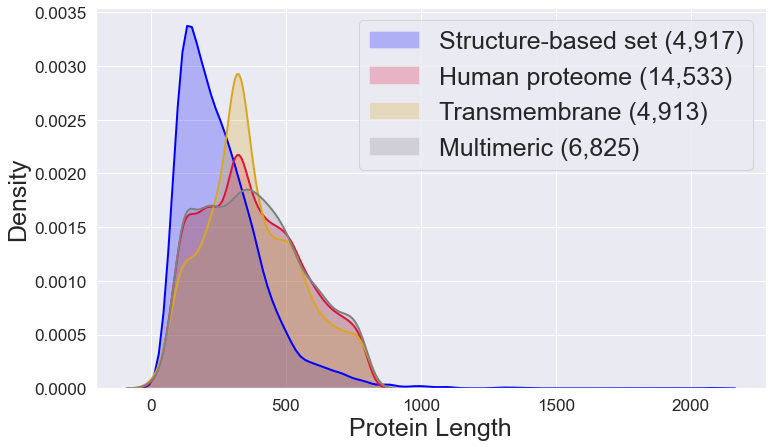

In [15]:
fig, ax = plt.subplots(0,0)
fig.set_size_inches(12, 7)

sns.distplot(lp_all['length'], hist=False, kde=True, color='Blue', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(hg['length'], hist=False, kde=True, color='crimson', kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(TM['length'], hist=False, kde=True, color='goldenrod',kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(COMP['length'], hist=False, kde=True, color='grey', kde_kws={'shade': True, 'linewidth': 2})

legend = ['Structure-based set (4,917)','Human proteome (14,533)', 'Transmembrane (4,913)', 'Multimeric (6,825)']
plt.legend(legend, prop={'size': 25}) #, title = 'Data Set')

plt.xlabel('Protein Length',  size=25)
plt.ylabel('Density',  size=25)
fig.savefig(file_path + '/ProteinLength.png', dpi = 150)

# THSA, RHSA and LHP Relationship

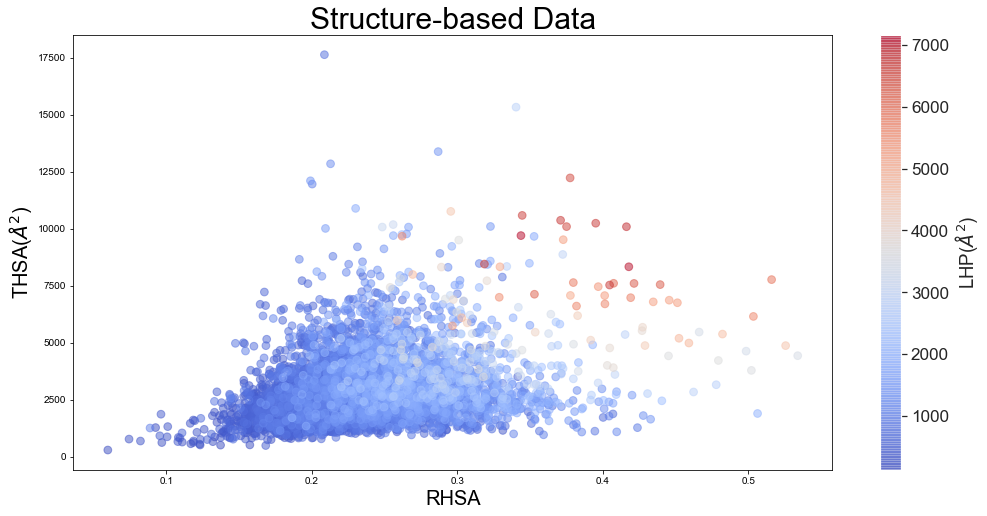

In [6]:
#sns.set_style(style='white')
fig , ax = plt.subplots(figsize = (17,8))
sns.set(font_scale = 1.55)

cm = plt.cm.get_cmap('coolwarm')
lp_all = lp_all.sort_values(by=['size'], ascending=True)

x = lp_all['rhsa']
y = lp_all['thsa']
colors = lp_all['size'] 

im = plt.scatter(x, y, s=60, c=colors, alpha=0.5, cmap=cm)
fig.colorbar(im, ax=ax, label='LHP($Å^2$)')
ax.set_xlabel('RHSA', fontsize=20)
ax.set_ylabel('THSA($Å^2$)', fontsize=20)
ax.set_title('Structure-based Data', fontsize=30)
plt.show()

fig.savefig(file_path + '/PDB_scatterplot.png', dpi = 150)

# The same plot for the human proteome data

fig , ax = plt.subplots(figsize = (17,8))
sns.set(font_scale = 1.55)

cm = plt.cm.get_cmap('coolwarm')
hg = hg.sort_values(by=['LHPSA'], ascending=True)

x = hg['RHSA']
y = hg['THSA']
colors =hg['LHPSA'] 

im = plt.scatter(x, y, s=60, c=colors, alpha=0.5, cmap=cm)
fig.colorbar(im, ax=ax, label='LHP($Å^2$)')
ax.set_xlabel('RHSA NSP2', fontsize=20)
ax.set_ylabel('THSA($Å^2$) NSP2', fontsize=20)
ax.set_title('Human Proteome Predictions', fontsize=30)
plt.show()
fig.savefig(file_path + '/hg_scatterplot.png', dpi = 150)

# Analysing GSEA on Disease pathways and overlapping proteins with KEGG ND gene sets

In [16]:
KEGG_PD = my_path + '/KEGG_PARKINSONS_DISEASE.tsv'
KEGG_PD = pd.read_csv(KEGG_PD, sep='\t', engine='python')
KEGG_PD = KEGG_PD.rename(columns = {'SYMBOL': 'Gene_ID'}, inplace = False)
KEGG_PD = pd.merge(hg, KEGG_PD, on='Gene_ID')

KEGG_HD = my_path + '/KEGG_HUNTINGTONS_DISEASE.tsv'
KEGG_HD = pd.read_csv(KEGG_HD, sep='\t', engine='python')
KEGG_HD = KEGG_HD.rename(columns = {'SYMBOL': 'Gene_ID'}, inplace = False)
KEGG_HD = pd.merge(hg, KEGG_HD, on='Gene_ID')

KEGG_AD = my_path + '/KEGG_ALZHEIMERS_DISEASE.tsv'
KEGG_AD = pd.read_csv(KEGG_AD, sep='\t', engine='python')
KEGG_AD = KEGG_AD.rename(columns = {'SYMBOL': 'Gene_ID'}, inplace = False)
KEGG_AD = pd.merge(hg, KEGG_AD, on='Gene_ID')

print('overlapping proteins with KEGG Parkinsons', KEGG_PD['length'].median(), 'amino acid residues')
print('overlapping proteins with KEGG Huntingtons', KEGG_HD['length'].median(), 'amino acid residues')
print('overlapping proteins with KEGG Alzheimers', KEGG_AD['length'].median(), 'amino acid residues')

overlapping proteins with KEGG Parkinsons 171.0 amino acid residues
overlapping proteins with KEGG Huntingtons 182.5 amino acid residues
overlapping proteins with KEGG Alzheimers 180.0 amino acid residues


# mRNA Expression Consensus data

In [18]:
consensus = my_path + '/HPA_RNA_CONSENSUS.tsv'
consensus = pd.read_csv(consensus, sep='\t', engine='python')

In [19]:
consensus = consensus.rename(columns = {'Gene name': 'Gene_ID'}, inplace = False)
consensus = pd.merge(hg, consensus, on='Gene_ID')

# Overall Hydrophobicity = Tissue-specific average surface hydrophobicity (TASH)

In [20]:
def tissue_hydrophobicity(df):
    df['NX_THSA'] = df['NX']*df['THSA']
    df['NX_RHSA'] = df['NX']*df['RHSA']
    df['NX_LHPSA'] = df['NX']*df['LHPSA']

    df['sum_NX']= df.groupby("Tissue")["NX"].transform('sum')
    df['sum_NX_THSA']= df.groupby("Tissue")["NX_THSA"].transform('sum')
    df['sum_NX_RHSA']= df.groupby("Tissue")["NX_RHSA"].transform('sum')
    df['sum_NX_LHPSA']= df.groupby("Tissue")["NX_LHPSA"].transform('sum')

    df['h_THSA'] = df['sum_NX_THSA']/df['sum_NX']
    df['h_RHSA'] = df['sum_NX_RHSA']/df['sum_NX']
    df['h_LHPSA'] = df['sum_NX_LHPSA']/df['sum_NX']
    df = df[['Tissue', 'h_THSA', 'h_RHSA', 'h_LHPSA']]
    df = df.drop_duplicates(subset=['Tissue'])
    
    return(df)

In [23]:
TASH = tissue_hydrophobicity(consensus)
TASH.columns = ['Tissue', 'THSA', 'RHSA', 'LHP']

In [24]:
TASH_THSA = TASH[['Tissue', 'THSA']].sort_values('THSA', ascending=False)
TASH_RHSA = TASH[['Tissue', 'RHSA']].sort_values('RHSA', ascending=False)
TASH_LHP = TASH[['Tissue', 'LHP']].sort_values('LHP', ascending=False)

In [29]:
s = TASH_THSA.style\
    .background_gradient(cmap='coolwarm', subset=['THSA'])
dfi.export(s, file_path + '/TASH_THSA.png')
s

,Tissue,THSA
35,parathyroid gland,6589.344140
8,cerebellum,6543.820250
12,corpus callosum,6406.807438
41,retina,6376.943688
37,placenta,6345.451364
53,thalamus,6324.745924
9,cerebral cortex,6320.775118
45,skin,6318.893971
36,pituitary gland,6277.653711
52,testis,6273.384076


In [30]:
s = TASH_RHSA.style\
    .background_gradient(cmap='coolwarm', subset=['RHSA'])
dfi.export(s, file_path + '/TASH_RHSA.png')
s

,Tissue,RHSA
42,salivary gland,0.303269
21,granulocytes,0.302792
34,pancreas,0.298075
17,epididymis,0.296657
13,dendritic cells,0.295775
30,monocytes,0.295740
25,kidney,0.295681
46,small intestine,0.294872
26,liver,0.294281
27,lung,0.293951


In [31]:
s = TASH_LHP.style\
    .background_gradient(cmap='coolwarm', subset=['LHP'])
dfi.export(s, file_path + '/TASH_LHP.png')
s

,Tissue,LHP
21,granulocytes,2065.153865
46,small intestine,2062.743761
42,salivary gland,2050.500048
25,kidney,2035.300969
41,retina,2026.744680
27,lung,2012.001148
9,cerebral cortex,1994.404812
12,corpus callosum,1992.950579
37,placenta,1986.760278
15,duodenum,1986.178344


# Relationship between mRNA expression data and THSA, RHSA, LHP values

In [10]:
consensus = my_path + '/HPA_RNA_CONSENSUS.tsv'
consensus = pd.read_csv(consensus, sep='\t', engine='python') #mRNA expression consensus data from HPA

consensus = consensus.rename(columns = {'Gene name': 'Gene_ID'}, inplace = False)
consensus = pd.merge(hg, consensus, on='Gene_ID')
#consensus_wtmp = consensus[~consensus['Uniprot_ID'].isin(TM_uniprot)] # without transmembrane proteins

# Analysis normalised expression (NX) value

In [11]:
#calculate median NX value per gene across all the tissues that a gene appears in
consensus['Median_NX'] = consensus.groupby(['Gene_ID'])['NX'].transform('median') 

In [36]:
#keep only one entry per gene by dropping duplicates 
#and keeping also the highest NX value per gene across the tissues
NX_median = consensus.sort_values('NX').drop_duplicates(subset=['Gene_ID'], keep='last') #df for analysing median NX value
NX_highest = consensus.sort_values('NX').drop_duplicates(subset=['Gene_ID'], keep='last') #df for analysing the highest NX value

# Highest NX value

In [37]:
NX_highest['NX'].describe()

count    13321.000000
mean        72.846813
std        165.585727
min          0.000000
25%         25.300000
50%         42.300000
75%         72.800000
max       6267.900000
Name: NX, dtype: float64

In [38]:
NX_highest['rows'] = np.arange(NX_highest.shape[0])
tenth = (len(NX_highest.iloc[:,0]))/10

In [39]:
def classifier_highest_NX(df):
    if df['rows'] <= tenth:
        return 'A'
    elif df['rows'] > tenth and df['rows'] <= 2*tenth:
        return 'B'
    elif df['rows'] > 2*tenth and df['rows'] <= 3*tenth:
        return 'C'
    elif df['rows'] > 3*tenth and df['rows'] <= 4*tenth:
        return 'D'
    elif df['rows'] > 4*tenth and df['rows'] <= 5*tenth:
        return 'E'
    elif df['rows'] > 5*tenth and df['rows'] <= 6*tenth:
        return 'F'    
    elif df['rows'] > 6*tenth and df['rows'] <= 7*tenth:
        return 'G'    
    elif df['rows'] > 7*tenth and df['rows'] <= 8*tenth:
        return 'H'    
    elif df['rows'] > 8*tenth and df['rows'] <= 9*tenth:
        return 'I'    
    elif df['rows'] > 9*tenth:
        return 'J'    
    
NX_highest['Expression'] = NX_highest.apply(classifier_highest_NX, axis=1)
NX_highest.to_csv(my_path +'/NX_highest.csv', sep= ',', index = False)

In [34]:
#To check the groups
#Expression = NX_highest.groupby('Expression').count() 

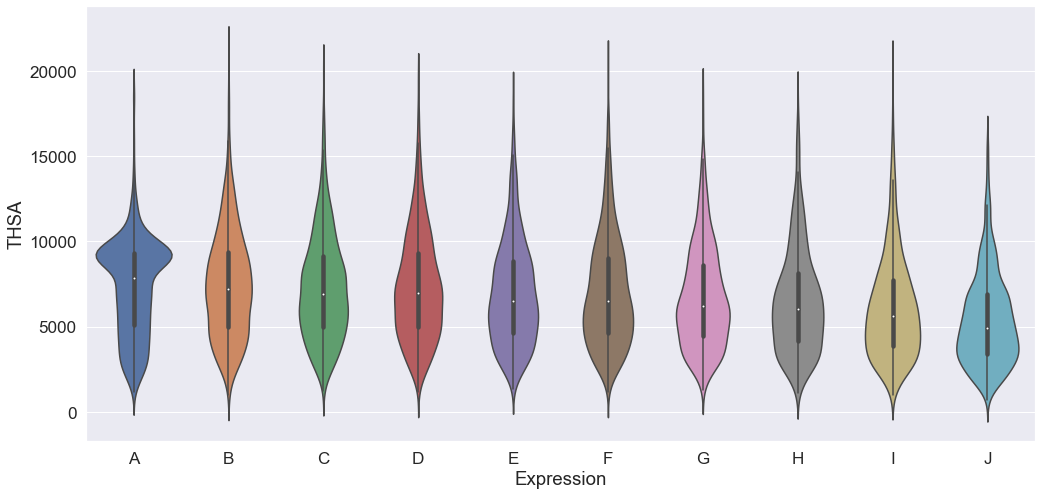

In [35]:
fig , ax = plt.subplots(figsize = (17,8))
sns.set(font_scale = 1.55)
ax = sns.violinplot(x="Expression", y="THSA", data=NX_highest)

#fig.savefig(file_path + '/NX_THSA.png', dpi = 150)

In [18]:
sns.set_style(style='white')

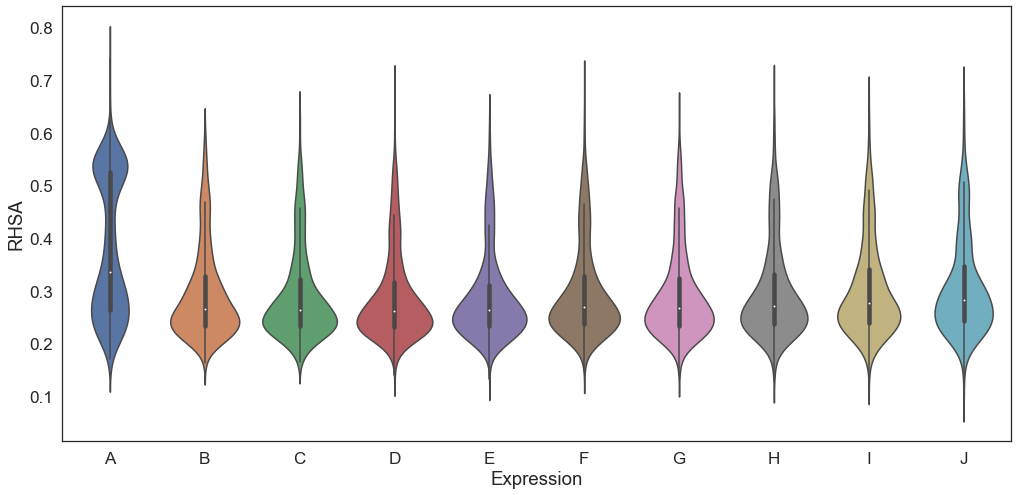

In [19]:
fig , ax = plt.subplots(figsize = (17,8))

sns.set(font_scale = 1.55)
ax = sns.violinplot(x="Expression", y="RHSA", data=NX_highest)
plt.show()

#fig.savefig(my_path + '.png', dpi = 150)

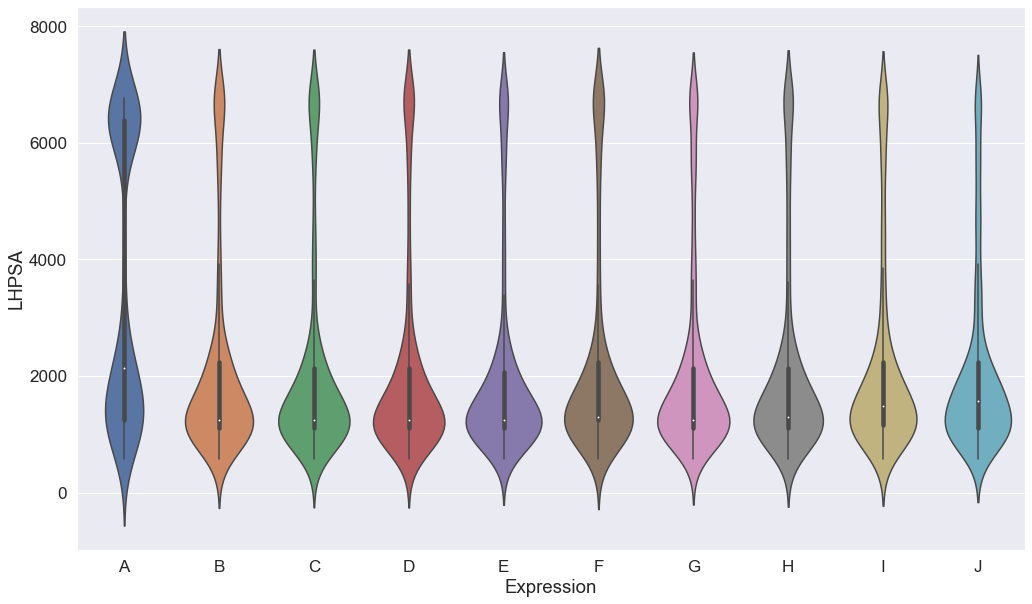

In [20]:
fig , ax = plt.subplots(figsize = (17,10))
sns.set_style(style='white')
sns.set(font_scale = 1.55)
ax = sns.violinplot(x="Expression", y="LHPSA", data=NX_highest)
plt.show()

#fig.savefig(my_path + '.png', dpi = 150)

# Median

In [40]:
NX_median = NX_median.sort_values('Median_NX')
NX_median['Median_NX'].describe()

count    13321.000000
mean         8.845961
std         11.772016
min          0.000000
25%          0.600000
50%          5.200000
75%         13.100000
max        142.000000
Name: Median_NX, dtype: float64

In [41]:
NX_median['rows'] = np.arange(NX_median.shape[0])
tenth = (len(NX_median.iloc[:,0]))/10

def classifier_median_NX(df):
    if df['rows'] <= tenth:
        return 'A'
    elif df['rows'] > tenth and df['rows'] <= 2*tenth:
        return 'B'
    elif df['rows'] > 2*tenth and df['rows'] <= 3*tenth:
        return 'C'
    elif df['rows'] > 3*tenth and df['rows'] <= 4*tenth:
        return 'D'
    elif df['rows'] > 4*tenth and df['rows'] <= 5*tenth:
        return 'E'
    elif df['rows'] > 5*tenth and df['rows'] <= 6*tenth:
        return 'F'    
    elif df['rows'] > 6*tenth and df['rows'] <= 7*tenth:
        return 'G'    
    elif df['rows'] > 7*tenth and df['rows'] <= 8*tenth:
        return 'H'    
    elif df['rows'] > 8*tenth and df['rows'] <= 9*tenth:
        return 'I'    
    elif df['rows'] > 9*tenth:
        return 'J'    
    
NX_median['Expression'] = NX_median.apply(classifier_median_NX, axis=1)
NX_median.to_csv(my_path +'/NX_median.csv', sep= ',', index = False)

In [23]:
#Check the groups
#Expression = NX_median.groupby('Expression').count()

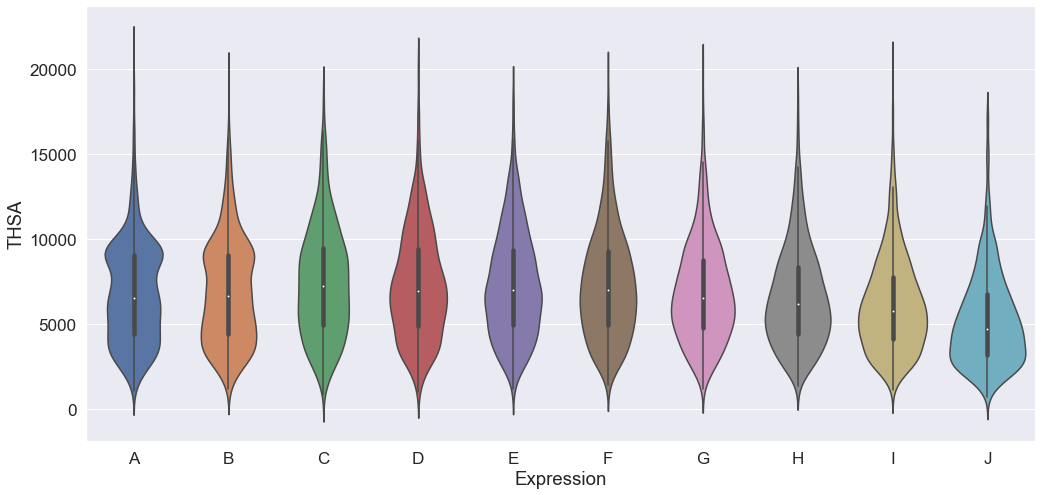

In [24]:
fig , ax = plt.subplots(figsize = (17,8))
sns.set_style(style='white')
sns.set(font_scale = 1.55)
ax = sns.violinplot(x="Expression", y="THSA", data=NX_median)
plt.show()

#fig.savefig(my_path + '.png', dpi = 150)

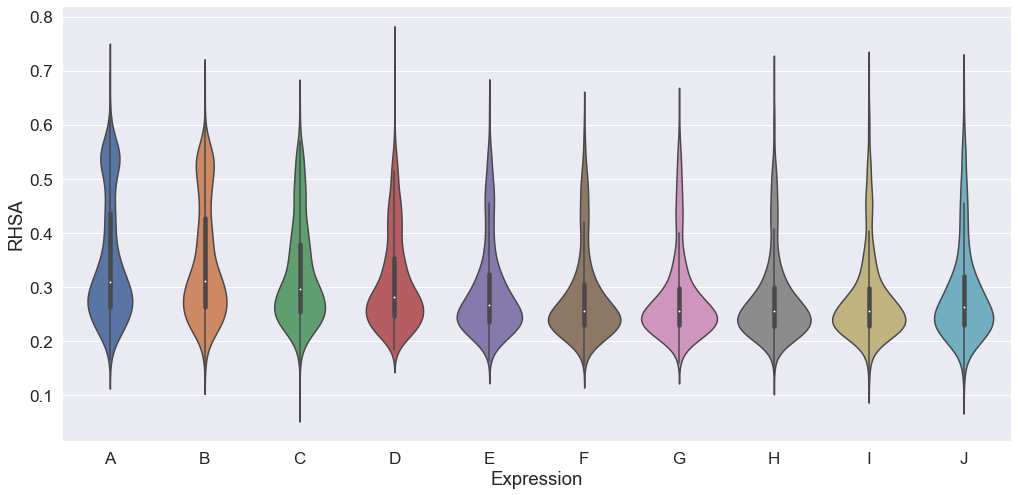

In [25]:
fig , ax = plt.subplots(figsize = (17,8))
sns.set_style(style='white')
sns.set(font_scale = 1.55)
ax = sns.violinplot(x="Expression", y="RHSA", data=NX_median)
plt.show()

#fig.savefig(my_path + '.png', dpi = 150)

In [26]:
sns.set_style(style='white')

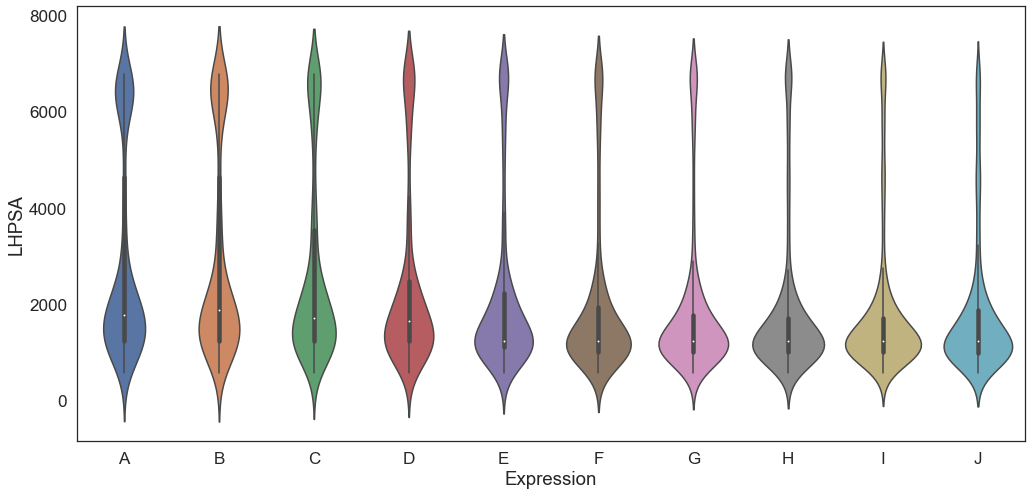

In [27]:
fig , ax = plt.subplots(figsize = (17,8))
sns.set(font_scale = 1.55)
ax = sns.violinplot(x="Expression", y="LHPSA", data=NX_median)
#plt.setp(ax.collections, alpha=.8)
plt.show()

#fig.savefig(my_path + '.png', dpi = 150)

# Analysing outliers, Check what kind of proteins are on top (high expression and high hydrophobicity)

In [28]:
NX_median_wtmp = NX_median[~NX_median['Uniprot_ID'].isin(TM_uniprot)] #removing transmembrane proteins
outliers = NX_median_wtmp[NX_median_wtmp['Expression'] == 'J']
outliers = outliers[outliers['RHSA'] > 0.4]
outliers = outliers[outliers['LHPSA'] > 2000]
outliers = outliers[outliers['THSA'] > 1500]
outliers = outliers.sort_values('NX')

all_uniprot = my_path + '/UNIPROT.tab' # need to import once again to have all the info
all_uniprot = pd.read_csv(all_uniprot, sep='\t', engine='python') #all information from Uniprot only
all_uniprot.columns = ['Uniprot_ID', 'x1', 'x2', 'x3', 'Gene_ID', 'Protein', 'x5', 'x6', 'length']
all_uniprot = all_uniprot[['Uniprot_ID', 'Protein']]
outliers = pd.merge(outliers, all_uniprot, on='Uniprot_ID')

In [44]:
outliers

,Uniprot_ID,Gene_ID,THSA,RHSA,LHPSA,length,Gene,Tissue,NX,Median_NX,rows,Expression,Protein
0,Q96B49,TOMM6,3509.937078,0.460378,3043.097619,74,ENSG00000214736,liver,92.6,48.7,13144,J,Mitochondrial import receptor subunit TOM6 hom...
1,O14548,COX7A2L,4719.836280,0.460295,4732.521667,114,ENSG00000115944,total PBMC,100.9,33.8,12869,J,Cytochrome c oxidase subunit 7A-related protei...
2,Q16553,LY6E,4345.042970,0.502790,4732.521667,131,ENSG00000160932,liver,127.1,23.3,12251,J,Lymphocyte antigen 6E (Ly-6E) (Retinoic acid-i...
3,O95178,NDUFB2,4327.596717,0.412029,4275.492381,105,ENSG00000090266,total PBMC,153.5,28.3,12629,J,NADH dehydrogenase [ubiquinone] 1 beta subcomp...
4,Q99732,LITAF,5397.239740,0.423116,4194.045714,161,ENSG00000189067,granulocytes,202.5,34.0,12875,J,Lipopolysaccharide-induced tumor necrosis fact...
5,P13987,CD59,4184.410638,0.421148,3794.482381,128,ENSG00000085063,placenta,285.5,44.3,13100,J,CD59 glycoprotein (1F5 antigen) (20 kDa homolo...
6,P30049,ATP5F1D,4638.496416,0.407998,4194.045714,168,ENSG00000099624,skeletal muscle,337.3,23.1,12215,J,"ATP synthase subunit delta, mitochondrial (ATP..."


# GSEA

In [29]:
brain = my_path + '/GSEA/HPA/brain_enriched.tsv'
blood = my_path + '/GSEA/HPA/blood_tissue_enriched.tsv'
kidney = my_path + '/GSEA/HPA/kidney_tissue_enriched.tsv'
liver = my_path + '/GSEA/HPA/liver_tissue_enriched.tsv'
skin = my_path + '/GSEA/HPA/skin_tissue_enriched.tsv'

brain = pd.read_csv(brain, sep='\t', engine='python')
blood = pd.read_csv(blood, sep='\t', engine='python')
kidney = pd.read_csv(kidney, sep='\t', engine='python')
liver = pd.read_csv(liver, sep='\t', engine='python')
skin = pd.read_csv(skin, sep='\t', engine='python')

In [35]:
brain['TM'] = np.where(brain['Uniprot'].isin(TM_uniprot), 1, 0)
brain['COMP'] = np.where(brain['Uniprot'].isin(COMPLEX_uniprot), 1, 0)

print(sum(brain['TM'])/len(brain.iloc[:,0]))
print(sum(brain['COMP'])/len(brain.iloc[:,0]))

0.4672131147540984
0.4672131147540984


In [36]:
blood['TM'] = np.where(blood['Uniprot'].isin(TM_uniprot), 1, 0)
blood['COMP'] = np.where(blood['Uniprot'].isin(COMPLEX_uniprot), 1, 0)

print(sum(blood['TM'])/len(blood.iloc[:,0]))
print(sum(blood['COMP'])/len(blood.iloc[:,0]))

0.47368421052631576
0.2807017543859649


In [37]:
kidney['TM'] = np.where(kidney['Uniprot'].isin(TM_uniprot), 1, 0)
kidney['COMP'] = np.where(kidney['Uniprot'].isin(COMPLEX_uniprot), 1, 0)

print(sum(kidney['TM'])/len(kidney.iloc[:,0]))
print(sum(kidney['COMP'])/len(kidney.iloc[:,0]))

0.7924528301886793
0.3584905660377358


In [38]:
liver['TM'] = np.where(liver['Uniprot'].isin(TM_uniprot), 1, 0)
liver['COMP'] = np.where(liver['Uniprot'].isin(COMPLEX_uniprot), 1, 0)

print(sum(liver['TM'])/len(liver.iloc[:,0]))
print(sum(liver['COMP'])/len(liver.iloc[:,0]))

0.2603305785123967
0.5991735537190083


In [39]:
skin['TM'] = np.where(skin['Uniprot'].isin(TM_uniprot), 1, 0)
skin['COMP'] = np.where(skin['Uniprot'].isin(COMPLEX_uniprot), 1, 0)

print(sum(skin['TM'])/len(skin.iloc[:,0]))
print(sum(skin['COMP'])/len(skin.iloc[:,0]))

0.07964601769911504
0.1592920353982301
